In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist
from scipy import stats

from src.downsample import downsamp_audio
import src.dimension_reducer as dr
import src.distance_metrics as dm
import src.plotting as plotting
import src.emb_manipulator as em


from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models. in any "all models" script we evaluate which one(s) might be best

#the directory has other csvs and i only want today's
#file = [file for file in os.listdir(embedding_dir) if file.startswith("020422") if 'emb' in file] 
#file = '022822_postpartum_moms_20part_emb_ami.csv'

#create a dictionary where each item is the pd df of the embeddings extracted from that model
#all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
#emb = ee.load_embs(os.path.join(embedding_dir,file))

file = '03016_diarized_pyv2.csv'

#create a dictionary where each item is the pd df of the embeddings extracted from that model
#all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
emb = pd.read_csv(os.path.join(embedding_dir,file), index_col=0)

#choose 'emb_ami' as the embedding model to use because it seemed to result in best preserved high-dimension structure when dimension reduced
#emb = all_embs[emb_models[0]]
emb_down = em.resample_data(emb,1)


#choose 'emb_ami' as the embedding model to use because it seemed to result in best preserved high-dimension structure when dimension reduced
#emb = all_embs[emb_models[0]]
#emb_down = ee.resample_data(emb,1)

#average emebdding for each participant
emb_a = em.embedding_averager(emb_down)

In [127]:
#Using tsne with perplexity=30 (default) since N/100<30, and learning rate of n/12. Random seed is 42 so the result is the same each time
emb_tsne = dr.run_tsne(emb_down, perplexity=60, init='pca', learning_rate=emb_down.shape[0]//12)
#emb_tsne = dr.run_tsne(emb_down, perplexity = 135, init='random')

# maximizing local strucure
# tsne: dom', learnining_rate=default
# umap: nearest_neighbor=6 perplexity = 15, init='ran, min_distance=10E-4

# maximizing global strucure
# tsne: perplexity = 135, init='random', learnining_rate=default
# umap: nearest_neighbor=14, min_distance=10E-3


#run umap with default parameters
emb_umap = dr.run_umap(emb_down)
#emb_umap = dr.run_umap(emb_down, neighbor = 14, dist=10E-3)

In [128]:
haus_tsne = dm.hausdorff_distances(emb_tsne)
haus_umap = dm.hausdorff_distances(emb_umap)

Processing row 19, col 19


In [129]:
part_list = emb_down.part_id.unique().astype('int32') 

#loo is leave one out. Creates a dictionary of the downsampled embeddings with the format: {participant_removed:embeddings} for each participant
loo = {'rm' + str(p):
       emb_down[emb_down.part_id!=part_list[idx]].reset_index(drop=True) 
       for idx,p in enumerate(part_list)
      }
part_list

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int32)

In [130]:
# Reduces dimensions of every set of leave-one-out
#Creates a dictionary: {participant_removed::two-dimension embeddings} for each participant with either tnse or umap

loo_tsne = {rm:dr.run_tsne(ed, perplexity=80, init='pca', learning_rate=emb_down.shape[0]//12) for rm, ed in loo.items()}
#loo_tsne = {rm:
#            dr.run_tsne(
#                ed, perplexity = 135, init='random') 
#            for rm, ed in loo.items()
#           }


In [131]:
loo_umap = {rm:dr.run_umap(ed) for rm, ed in loo.items()}
#loo_umap = {rm:
#            dr.run_umap(ed, neighbor = 14, dist=10E-3) 
#            for rm, ed in loo.items()
#           }

In [132]:
#Calculates hausdorf distances between each participants point-cloud after dim reduc
#Creates a dictionary: {participant_removed:hausdorf distance} for each participant
#with hausdorff distances between each participant's two-dimension point-cloud, on either the tsne or umap

loo_haus_tsne = {rm:dm.hausdorff_distances(e2d) for rm, e2d in loo_tsne.items()}

Processing row 18, col 18


In [137]:
loo_haus_umap = {rm:dm.hausdorff_distances(e2d) for rm, e2d in loo_umap.items()}

Processing row 18, col 18


In [138]:
for p in loo_haus_tsne.keys():
    loo_haus_tsne[p].loc[int(p.replace('rm', ''))] = np.nan
    loo_haus_tsne[p].sort_index(inplace=True)
    loo_haus_tsne[p][int(p.replace('rm', ''))] = np.nan
    loo_haus_tsne[p] = loo_haus_tsne[p].reindex(sorted(loo_haus_tsne[p].columns), axis=1)

for p in loo_haus_umap.keys():
    loo_haus_umap[p].loc[int(p.replace('rm', ''))] = np.nan
    loo_haus_umap[p].sort_index(inplace=True)
    loo_haus_umap[p][int(p.replace('rm', ''))] = np.nan
    loo_haus_umap[p] = loo_haus_umap[p].reindex(sorted(loo_haus_umap[p].columns), axis=1)

In [139]:
loo_haus_tsne_flat = {rm:
                      np.hstack((
                          haus.to_numpy()[np.triu_indices(part_list.size, k=1)],
                          haus.to_numpy()[np.tril_indices(part_list.size, k=-1)]
                      ))
                      for rm,haus in loo_haus_tsne.items()
                     }

loo_haus_umap_flat = {rm:
                      np.hstack((
                          haus.to_numpy()[np.triu_indices(part_list.size, k=1)],
                          haus.to_numpy()[np.tril_indices(part_list.size, k=-1)]
                      ))
                      for rm,haus in loo_haus_umap.items()
                     }

haus_tsne_flat = np.hstack((
                          haus_tsne.to_numpy()[np.triu_indices(part_list.size, k=1)],
                          haus_tsne.to_numpy()[np.tril_indices(part_list.size, k=-1)]
))

haus_umap_flat = np.hstack((
                          haus_umap.to_numpy()[np.triu_indices(part_list.size, k=1)],
                          haus_umap.to_numpy()[np.tril_indices(part_list.size, k=-1)]
))

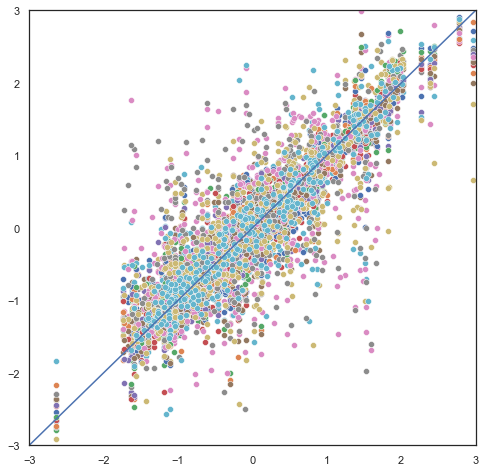

In [186]:
fig, ax = plt.subplots(figsize=(8,8))
[sns.scatterplot(
    x=haus_tsne_flat, y=haus,palette="Paired", 
    ) 
 for haus in loo_haus_tsne_flat.values()]

plt.xlim([-3,3])
plt.ylim([-3,3])

sns.lineplot(x=[-3,3], y=[-3,3])
plt.show()

In [183]:
corr_coeff = pd.DataFrame()
haus_tsne_flat_df = pd.DataFrame(haus_tsne_flat)
for haus in loo_haus_tsne_flat.values():
    haus = pd.DataFrame(haus)
    corr_coeff = pd.concat([corr_coeff, haus_tsne_flat_df.corrwith(haus)], ignore_index=True)
corr_coeff['rm'] = loo_haus_tsne_flat.keys()

In [184]:
corr_coeff

,0,rm
0,0.959766,rm1
1,0.949203,rm2
2,0.970659,rm3
3,0.959703,rm4
4,0.959910,rm5
5,0.919107,rm6
6,0.883310,rm7
7,0.946060,rm8
8,0.786855,rm9
9,0.820654,rm10


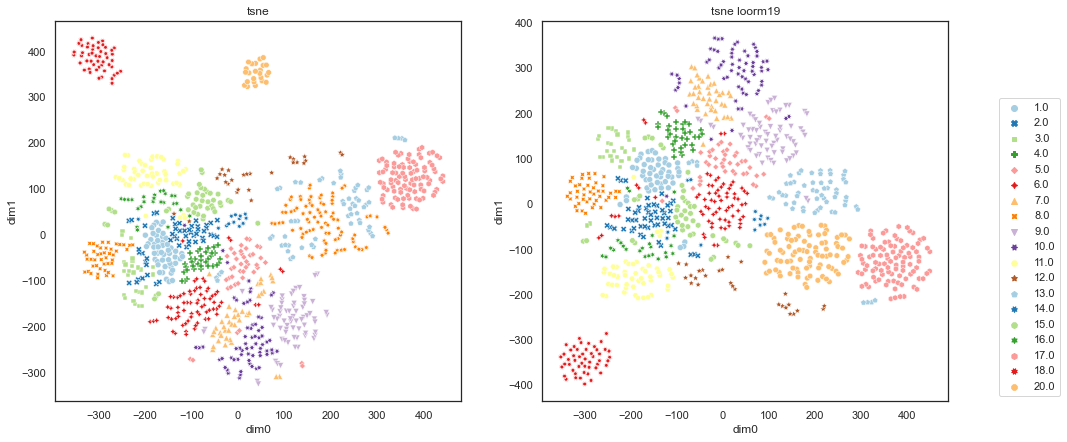

In [202]:
part_r = 'rm19'
test = loo_tsne[part_r]

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16,7))

clust_plt_tsne = sns.scatterplot(x=emb_tsne.dim0, y=emb_tsne.dim1, palette="Paired", 
                                 ax=ax1, hue=emb_tsne.part_id, style=emb_tsne.part_id, legend=False)
clust_plt_tsne.set(title = 'tsne')

clust_plt_tsne_loo = sns.scatterplot(x=test.dim0, y=test.dim1, palette="Paired", 
                                 ax=ax2, hue=test.part_id, style=test.part_id)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2, 0), ncol=1)
clust_plt_tsne_loo.set(title = 'tsne loo' + str(part_r))


plt.show()

In [14]:
metrics = {rm:dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        subsetsize=X.shape[0]
)
 for ([rm,X],Z) in zip(loo.items(), loo_tsne.values())
}

#metrics = {rm:dm.embedding_quality(
#        emb_down.drop(columns='part_id').to_numpy(), 
#        Z.drop(columns='part_id').to_numpy(), 
#        emb_down.part_id.to_numpy(),
#        subsetsize=1000
#)
# for rm,Z in loo_tsne.items()
#}


metrics = pd.DataFrame(metrics.values(), columns=['micro', 'meso', 'macro'], index = metrics.keys())
metrics.mean(axis=0)


micro    0.271056
meso     0.806053
macro    0.593348
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

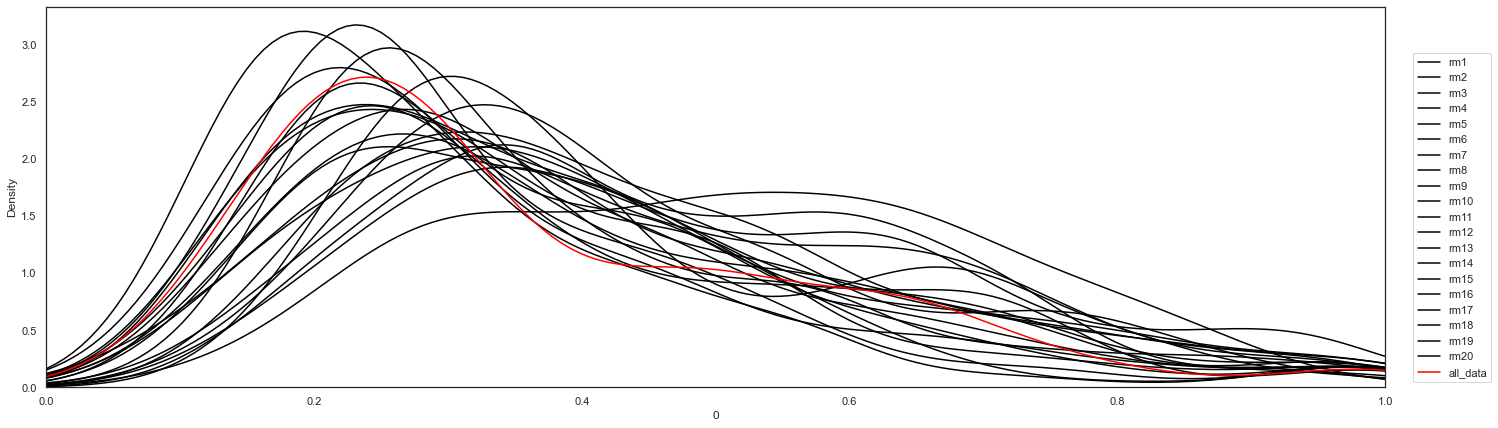

In [44]:
#plots distribution all hausdorff distances. Technically a histogram with easily viewing
fig, ax = plt.subplots(figsize=(24,7))#ncols=3
bins=100

d_plot = [sns.distplot(dist,hist=False, norm_hist=True,label=rm,color='black') for rm,dist in loo_haus_tsne_flat.items()]
a_plot = sns.distplot(haus_tsne_flat,hist=False, norm_hist=True,label='all_data',color='red')
ax.legend(loc="lower center",bbox_to_anchor=(1.05, 0), ncol=1)
plt.xlim(0,1)
plt.show

In [75]:
#Using tsne with perplexity=30 (default) since N/100<30, and learning rate of n/12. Random seed is 42 so the result is the same each time
emb_tsne = dr.run_tsne(emb_down, perplexity=80, init='pca', learning_rate=emb_down.shape[0]//12)
haus_tsne = dm.hausdorff_distances(emb_tsne)

Processing row 19, col 19


In [33]:
haus_tsne_flat = haus_tsne.stack().reset_index().iloc[:,2]  

haus_tsne_flat = haus_tsne_flat[haus_tsne_flat>0]
haus_tsne_flat

1      0.201617
2      0.159276
3      0.213192
4      0.212280
5      0.275035
         ...   
394    0.387642
395    0.374027
396    0.191426
397    0.740169
398    0.231070
Name: 0, Length: 380, dtype: float64

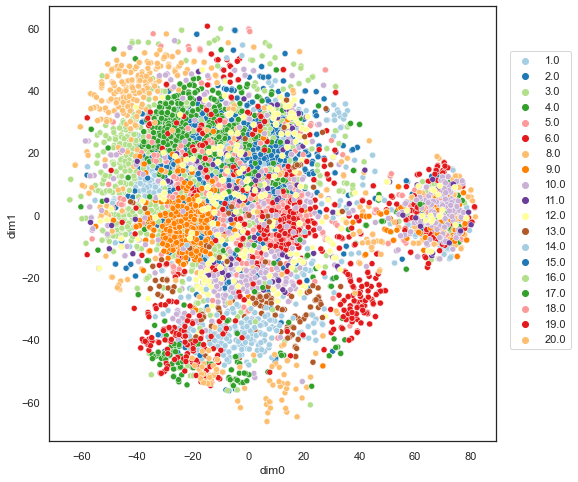

In [77]:
#ttest = dm.loo_t_test(loo_haus_tsne_flat,equal_var=False)
ttest = [stats.ttest_ind(rm,haus_tsne_flat,equal_var=False) for rm in loo_haus_tsne_flat.values()]
a = pd.DataFrame(ttest)
#np.sum(a.pvalue<0.05)

figure, ax = plt.subplots(figsize=(8,8))
rm = 'rm7'
#sns.scatterplot(x='dim0', y='dim1',data=loo_tsne[rm],hue=loo_tsne[rm].part_id, palette="Paired")
sns.scatterplot(x='dim0', y='dim1',data=emb_tsne,hue=loo_tsne[rm].part_id, palette="Paired",)
ax.legend(loc="lower center",bbox_to_anchor=(1.1,0.2))


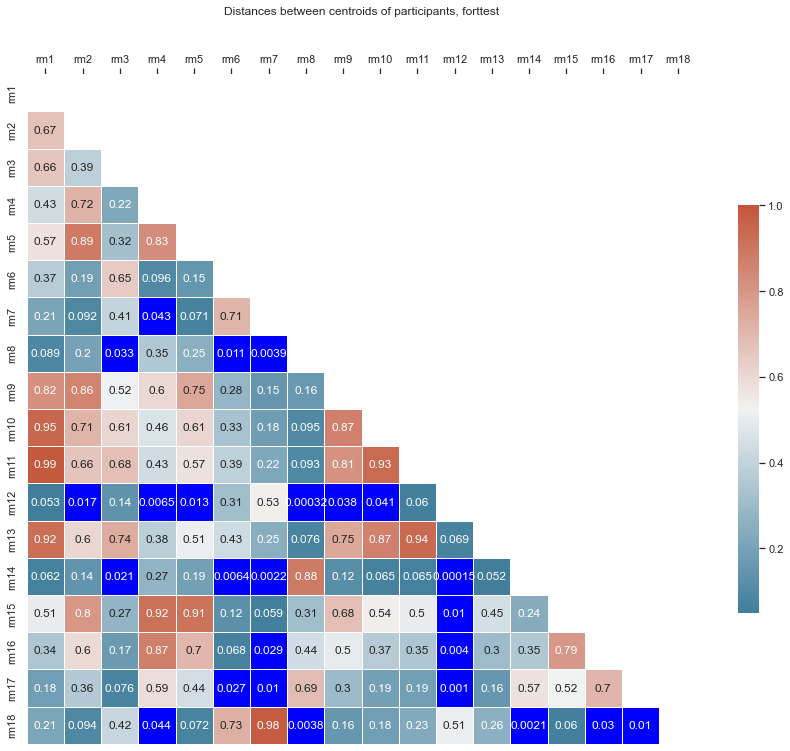

In [52]:
plotting.plot_norm_heatmap(ttest,'ttest')

In [74]:
temp = pd.DataFrame(np.triu(ttest, k=1).flatten())
temp = temp[temp>0].dropna()
temp.ge(0.05).mean().mul(100)


0    83.660131
dtype: float64

In [ ]:
reset_index